# CompSpec Comparison

## Intro
* **Date**: 11/30/2020
* **What**: This is mini-experiment comparing CompSpec with simply initializing weights with random data points.
* **Why**: Because I think I spent a week stressing over CompSpec, and it really only does this.
* **Hopes**: CompSpec outperforms simple initialization.
* **Limitations**: This is a mini-experiment, go fuck yourself.

## Code

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from time import time
from tensorflow.keras.datasets import mnist
from tqdm import tqdm

L = 28 * 28   #Size of mnist in pixels
S = 60000     #Size of training set

(train_X, train_y), (test_X, test_y) = mnist.load_data()
train_X = train_X / 255.0

flat_x = np.reshape(train_X, [-1, L])
flat_test = np.reshape(test_X, [-1, L])

In [2]:
def wta_classification(w, T_s):
    flat_x = np.reshape(train_X, [-1, L])
    flat_test = np.reshape(test_X, [-1, L])
    
    v = flat_x[:T_s]
    train_lbls = train_y[:T_s]
    
    v = v / np.array([np.linalg.norm(v, axis=1)]).T
    w = w / np.array([np.linalg.norm(w, axis=1)]).T
    
    wins = np.argmax(w @ (flat_x[:T_s, :]).T, axis=0)
    
    n_wins = np.zeros((w.shape[0], 10))
    
    for (n_i, lbl) in zip(wins, train_lbls):
        n_wins[n_i][lbl] += 1
        
    n_cls = np.argmax(n_wins, axis=1)
    print("Neuron classes:", n_cls)
    
    num_test = test_y.shape[0]
    test_v = flat_test / np.array([np.linalg.norm(flat_test, axis=1)]).T
    
    num_correct = 0
    
    incorrect = np.zeros(10)
    
    for i in range(num_test):
        w_mul_v = w @ test_v[i].T
        
        n_max = np.argmax(w_mul_v)
        
        pre = n_cls[n_max]
        if pre == test_y[i]:
            num_correct += 1
        else:
            incorrect[test_y[i]] += 1
            
    print("Accuracy:", str(num_correct * 100 / num_test) + '%')
    print("Misclassifieds: ", incorrect)

In [4]:
def draw_weights(synapses, Kx, Ky):
    yy=0
    HM=np.zeros((28*Ky,28*Kx))
    for y in range(Ky):
        for x in range(Kx):
            HM[y*28:(y+1)*28,x*28:(x+1)*28]=synapses[yy,:].reshape(28,28)
            yy += 1
    plt.clf()
    nc=np.amax(np.absolute(HM))
    im=plt.imshow(HM,cmap='bwr',vmin=-nc,vmax=nc)
    fig.colorbar(im,ticks=[0, np.amax(HM)])
    plt.axis('off')
    fig.canvas.draw()   

In [4]:
"""
flat_x: training data
S: Size of training set
L: Size of input
Kx: Num cols of neurons
Ky: Num rows of neurons
Nep: Num epochs
T_s: Number of training inputs
xi: Base learning constant
phi: Specialization ema constant
B: Batch size

zeta: Brutality of exponent
beta: giver of life lol

Returns: (synapse_weights, neuron specialization values)
"""
def run_comp_spec_mb(flat_x, S, L, Kx, Ky, Nep, T_s, xi, phi, B, zeta, beta):
    start = time()
    N = Kx * Ky
    
    w = np.abs(np.random.normal(0, 1, (N, L))) # synapses of each neuron
    w = w / np.array([np.linalg.norm(w, axis=1)]).T #NORMALIZE THE WEIGHTS TO PREVENT EXXXPLOSIONS
    s = np.zeros(N).reshape(-1, 1) # Specialization for each neuron+

    for ep in range(Nep):
        # Uncomment the following line if you'd like to shuffle the data between epochs
        inputs = flat_x[np.random.permutation(S), :].reshape(S, L)

        for i in tqdm(range(T_s // B)):
            v = inputs[i * B: (i + 1) * B, :]

            w_mul_v = w @ v.T 
            o = w_mul_v / (np.linalg.norm(w, axis=1).reshape(-1, 1) * np.linalg.norm(v, axis=1))

            c = (np.exp(-1 * zeta * s) + beta) / (1 - o)

            wins = np.argmax(c, axis=0)     

            win_mask = np.zeros((N, B))
            win_mask[wins, np.arange(B)] = 1
            win_mask = (win_mask / np.maximum(np.sum(win_mask, axis=1), 1).reshape(-1, 1))

            win_avg = (np.sum(w_mul_v * win_mask, axis=1)).reshape(-1, 1)

            v_update = win_mask @ v

            del_syn = (v_update - (win_avg * w)) * (np.exp(-1 * zeta * s) + beta) * xi

            w += del_syn

            s[wins] *= (1 - phi)
            s += phi * np.sum(o * win_mask, axis=1).reshape(-1, 1)

        draw_weights(w, Kx, Ky)

    print("Max val: ", np.amax(s), "Min value: ", np.amin(s), "Mean val: ", np.mean(s), "Std: ", np.std(s))
    print("Elapsed time: ", time() - start, " seconds")
    
    return (w, s)

100%|██████████| 600/600 [00:02<00:00, 267.02it/s]


Max val:  0.6442936469048826 Min value:  0.4910801470005186 Mean val:  0.5715493302748991 Std:  0.0271901894943813
Elapsed time:  2.983499050140381  seconds



Neuron classes: [8 1 4 7 2 8 2 6 2 8 8 4 0 1 9 1 3 9 6 1 3 7 3 9 9 0 0 9 2 7 6 7 0 3 4 0 0
 9 6 3 7 6 5 5 6 9 7 4 1 9 6 0 5 3 5 2 2 3 5 1 9 1 6 0 0 1 1 7 1 6 7 5 1 4
 0 6 7 7 1 9 3 0 1 1 7 0 1 3 8 9 0 7 3 6 6 9 3 5 4 2]
Accuracy: 86.11%
Misclassifieds:  [ 19.  17. 110.  67. 370. 216.  49. 114. 286. 141.]


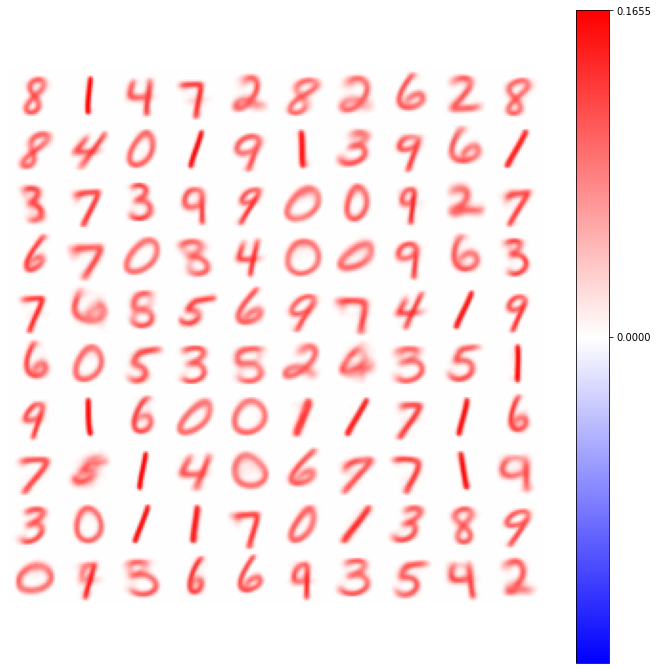

In [5]:
%matplotlib inline
# %matplotlib notebook
fig=plt.figure(figsize=(12,12))

Kx = 10
Ky = 10
Nep = 1
T_s = 60000
xi = 0.1
phi = 2 / 501

zeta = 20
beta = 0.01

B = 100 #Batch size

(w, _) = run_comp_spec_mb(flat_x, S, L, Kx, Ky, Nep, T_s, xi, phi, B, zeta, beta)
print("\n\n")
wta_classification(w, T_s)
draw_weights(w, Kx, Ky)

100%|██████████| 600/600 [00:00<00:00, 723.90it/s]


Max val:  0.7526078562709034 Min value:  0.3257975999549343 Mean val:  0.6195546619216971 Std:  0.06531328937529245
Elapsed time:  1.0888545513153076  seconds
Neuron classes: [5 0 4 1 4 2 1 5 1 4 3 5 3 6 1 7 2 8 8 9 9 0 4 1 3 2 9 3 2 7 9 8 6 7 6 5 6
 0 2 6 3 8 7 7 3 4 8 5 4 5 3 0 7 4 9 8 0 9 4 8 4 2 6 0 4 5 6 1 0 8 2 7 1 2
 3 5 2 1 1 4 5 0 2 6 7 3 3 5 0 9 6 7 9 6 8 0 7 3 3 9]
Accuracy: 88.03%
Misclassifieds:  [ 30.  29. 110. 116. 233. 132.  39. 136. 180. 192.]


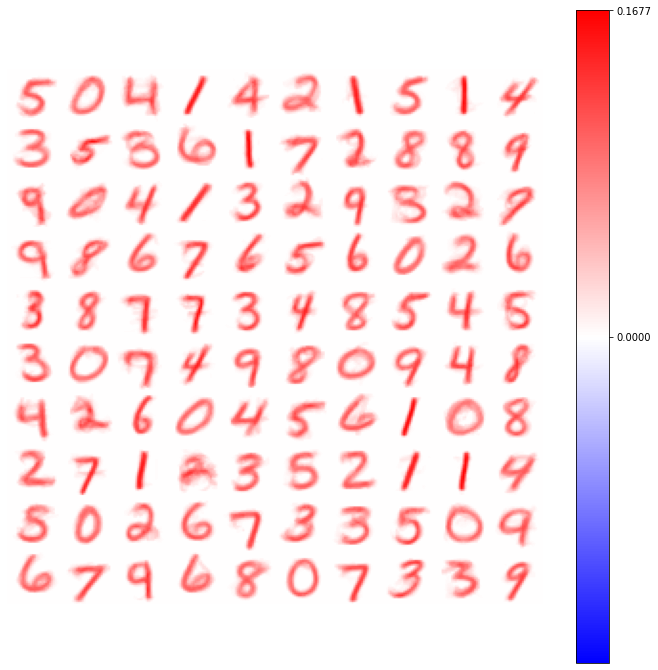

In [17]:
%matplotlib inline
# %matplotlib notebook
fig=plt.figure(figsize=(12,12))

Kx = 10
Ky = 10
Nep = 1
T_s = 60000
xi = 0.02
phi = 2 / 501

zeta = 20
beta = 0.001

B = 100 #Batch size

start = time()
N = Kx * Ky

w = flat_x[:N, :]
# w = np.abs(np.random.normal(0, 1, (N, L))) # synapses of each neuron
w = w / np.array([np.linalg.norm(w, axis=1)]).T #NORMALIZE THE WEIGHTS TO PREVENT EXXXPLOSIONS
s = np.zeros(N).reshape(-1, 1) # Specialization for each neuron+

for ep in range(Nep):
    # Uncomment the following line if you'd like to shuffle the data between epochs
    inputs = flat_x[np.random.permutation(S), :].reshape(S, L)

    for i in tqdm(range(T_s // B)):
        v = inputs[i * B: (i + 1) * B, :]

        w_mul_v = w @ v.T 
        o = w_mul_v / (np.linalg.norm(w, axis=1).reshape(-1, 1) * np.linalg.norm(v, axis=1))

#         c = (np.exp(-1 * zeta * s) + beta) / (1 - o)
        
        c = o

        wins = np.argmax(c, axis=0)     

        win_mask = np.zeros((N, B))
        win_mask[wins, np.arange(B)] = 1
        win_mask = (win_mask / np.maximum(np.sum(win_mask, axis=1), 1).reshape(-1, 1))

        win_avg = (np.sum(w_mul_v * win_mask, axis=1)).reshape(-1, 1)

        v_update = win_mask @ v

        del_syn = (v_update - (win_avg * w)) * xi

        w += del_syn

        s[wins] *= (1 - phi)
        s += phi * np.sum(o * win_mask, axis=1).reshape(-1, 1)

    draw_weights(w, Kx, Ky)

print("Max val: ", np.amax(s), "Min value: ", np.amin(s), "Mean val: ", np.mean(s), "Std: ", np.std(s))
print("Elapsed time: ", time() - start, " seconds")

wta_classification(w, T_s)
draw_weights(w, Kx, Ky)

## Analysis Dialog

Well, it seems as though there isn't a huge difference between CompSpec and random weight initialization.  Just looking at the two, it looks like the prototypes CompSpec learns simply look a bit better, but they're both getting about the same wta classification accuracy. I'm going to try this with 400, then 1,600 neurons and see what's up.

100%|██████████| 150/150 [00:02<00:00, 50.95it/s]


Max val:  0.36694994331605807 Min value:  0.05577215024297914 Mean val:  0.22044750547480468 Std:  0.058581703506445655
Elapsed time:  3.2397003173828125  seconds



Neuron classes: [4 5 5 1 8 5 3 5 4 9 6 6 2 0 7 4 4 9 4 7 2 6 7 6 0 7 9 4 3 5 7 5 5 7 8 2 2
 9 6 6 8 7 1 8 8 8 0 1 5 3 2 7 6 4 5 2 3 9 7 7 5 0 9 0 8 3 0 7 2 6 5 2 6 3
 6 4 0 5 9 3 2 3 7 6 0 2 5 0 0 0 5 9 7 6 4 3 1 0 9 8 4 8 3 9 8 3 6 5 0 5 3
 7 2 7 9 2 2 2 1 3 7 2 2 8 8 3 3 0 7 7 2 7 4 4 5 2 6 0 6 2 0 0 1 3 6 5 3 8
 6 8 8 3 5 4 1 5 0 6 6 7 8 8 8 7 4 7 5 1 6 4 8 1 6 5 0 8 2 0 4 4 9 9 7 5 0
 6 5 6 7 7 9 3 4 6 0 2 5 5 3 9 8 9 6 2 1 0 3 0 7 4 6 8 2 2 5 2 7 2 0 9 0 2
 7 3 8 2 6 4 1 0 3 9 9 6 3 6 9 9 4 8 5 9 0 3 6 9 5 9 9 7 9 1 7 5 9 3 7 3 9
 0 3 2 0 2 8 9 0 6 0 1 1 3 2 7 4 1 3 4 3 1 2 4 7 9 8 6 7 4 0 9 3 1 1 0 9 9
 8 6 5 5 1 4 2 7 4 9 2 0 8 1 2 1 0 2 4 4 7 6 7 9 2 8 3 0 1 8 2 1 2 0 5 3 2
 5 3 2 6 5 2 0 7 9 2 7 4 8 0 2 8 0 0 0 2 9 1 9 0 3 9 3 2 8 3 6 2 4 3 2 6 9
 8 1 5 4 6 4 7 1 4 7 5 1 6 0 4 6 2 6 7 2 4 4 7 8 1 9 0 0 9 4]
Accura

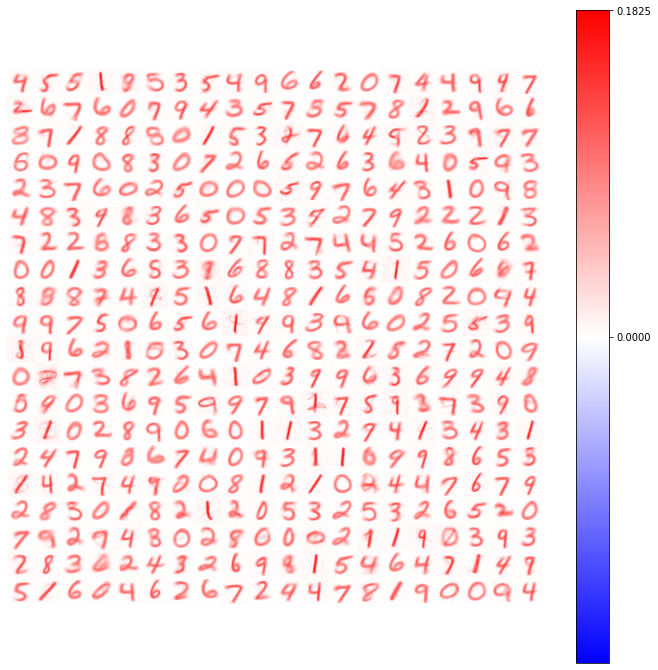

In [6]:
%matplotlib inline
# %matplotlib notebook
fig=plt.figure(figsize=(12,12))

Kx = 20
Ky = 20
Nep = 1
T_s = 60000
xi = 0.1
phi = 2 / 501

zeta = 200
beta = 0.01

B = 400 #Batch size

(w, _) = run_comp_spec_mb(flat_x, S, L, Kx, Ky, Nep, T_s, xi, phi, B, zeta, beta)
print("\n\n")
wta_classification(w, T_s)
draw_weights(w, Kx, Ky)

100%|██████████| 600/600 [00:05<00:00, 118.89it/s]


Max val:  0.0 Min value:  0.0 Mean val:  0.0 Std:  0.0
Elapsed time:  5.316780090332031  seconds
Neuron classes: [5 0 4 1 9 2 1 3 1 4 3 5 8 6 1 7 2 8 6 9 9 3 9 1 1 2 4 3 2 7 3 8 6 9 0 5 6
 0 2 6 1 8 7 9 5 9 8 5 3 5 3 0 7 4 4 8 0 9 4 1 9 4 6 0 4 5 6 1 0 5 2 7 1 6
 3 0 2 1 3 7 5 0 2 6 7 8 3 9 0 4 6 7 4 6 8 0 7 8 3 7 5 7 1 7 1 1 8 3 5 2 4
 5 1 1 0 4 9 2 0 0 2 0 2 7 1 5 5 4 8 6 3 4 3 7 1 3 3 8 5 4 7 4 4 2 8 5 8 6
 2 3 4 6 1 9 9 6 0 8 7 2 8 2 9 4 4 6 4 9 7 0 9 2 7 5 1 5 9 8 2 3 2 8 3 9 1
 8 6 2 8 2 2 5 0 7 4 9 7 8 3 2 1 1 8 3 6 1 0 3 1 0 0 1 7 2 7 3 5 4 6 5 2 6
 9 7 1 8 9 7 8 0 7 1 8 2 0 5 5 4 6 5 8 6 3 7 5 8 0 9 1 0 7 0 2 2 3 3 6 4 7
 5 0 6 2 7 4 8 5 9 2 1 1 4 4 5 6 4 1 2 3 3 9 3 9 6 8 9 6 0 7 4 1 3 4 0 4 8
 0 4 5 6 8 7 6 0 9 7 5 7 2 1 1 6 8 4 4 1 3 2 2 9 0 3 9 6 7 2 0 3 5 4 5 4 5
 8 9 5 4 7 4 2 7 3 9 8 9 1 5 2 8 7 4 1 5 7 4 1 3 1 1 0 2 3 9 4 9 2 1 6 2 4
 7 7 4 4 9 2 5 9 2 4 6 2 1 9 7 2 8 7 6 9 2 2 3 8 1 6 5 1 1 0]
Accuracy: 92.38%
Misclassifieds:  [ 13.   9.  68. 102. 110. 107.  36.  96. 

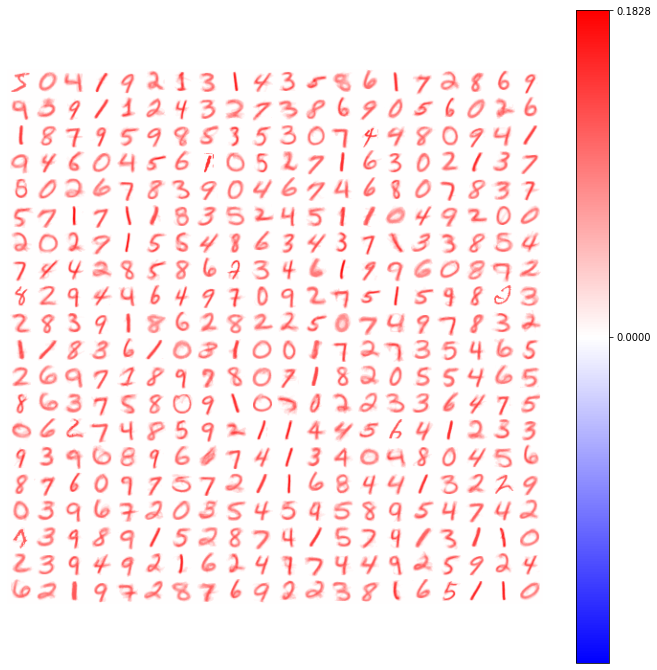

In [20]:
%matplotlib inline
# %matplotlib notebook
fig=plt.figure(figsize=(12,12))

Kx = 20
Ky = 20
Nep = 1
T_s = 60000
xi = 0.02
phi = 2 / 501

zeta = 20
beta = 0.001

B = 100 #Batch size

start = time()
N = Kx * Ky

w = flat_x[:N, :]
# w = np.abs(np.random.normal(0, 1, (N, L))) # synapses of each neuron
w = w / np.array([np.linalg.norm(w, axis=1)]).T #NORMALIZE THE WEIGHTS TO PREVENT EXXXPLOSIONS
s = np.zeros(N).reshape(-1, 1) # Specialization for each neuron+

for ep in range(Nep):
    # Uncomment the following line if you'd like to shuffle the data between epochs
    inputs = flat_x[np.random.permutation(S), :].reshape(S, L)

    for i in tqdm(range(T_s // B)):
        v = inputs[i * B: (i + 1) * B, :]

        w_mul_v = w @ v.T 
        o = w_mul_v / (np.linalg.norm(w, axis=1).reshape(-1, 1) * np.linalg.norm(v, axis=1))

        c = o

        wins = np.argmax(c, axis=0)     

        win_mask = np.zeros((N, B))
        win_mask[wins, np.arange(B)] = 1
        win_mask = (win_mask / np.maximum(np.sum(win_mask, axis=1), 1).reshape(-1, 1))

        win_avg = (np.sum(w_mul_v * win_mask, axis=1)).reshape(-1, 1)

        v_update = win_mask @ v

        del_syn = (v_update - (win_avg * w)) * xi

        w += del_syn

    draw_weights(w, Kx, Ky)

print("Max val: ", np.amax(s), "Min value: ", np.amin(s), "Mean val: ", np.mean(s), "Std: ", np.std(s))
print("Elapsed time: ", time() - start, " seconds")

wta_classification(w, T_s)
draw_weights(w, Kx, Ky)

100%|██████████| 120/120 [00:10<00:00, 11.99it/s]


Max val:  0.20125319679060344 Min value:  0.03453204787401179 Mean val:  0.0651231621051173 Std:  0.021035998546039866
Elapsed time:  10.446642398834229  seconds



Neuron classes: [1 2 8 ... 5 0 3]
Accuracy: 92.93%
Misclassifieds:  [ 16.  13.  59.  88.  86.  89.  27.  98. 111. 120.]


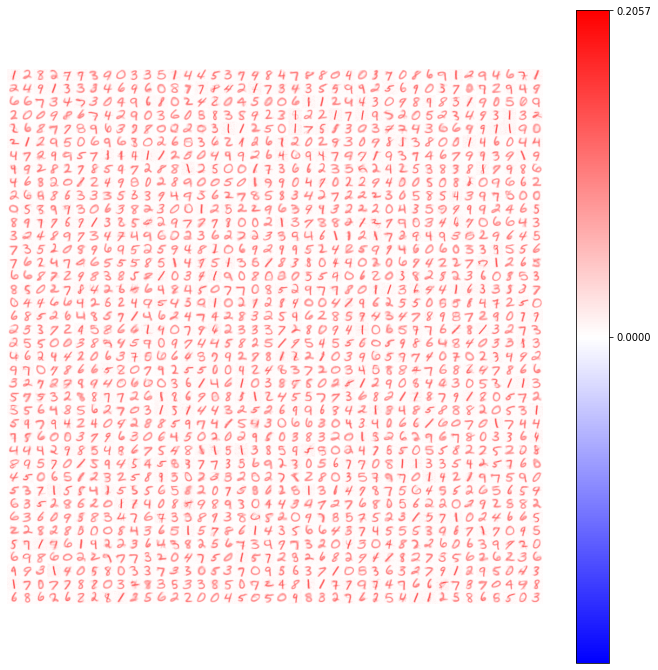

In [7]:
%matplotlib inline
# %matplotlib notebook
fig=plt.figure(figsize=(12,12))

Kx = 40
Ky = 40
Nep = 1
T_s = 60000
xi = 0.1
phi = 2 / 501

zeta = 200
beta = 0.01

B = 500 #Batch size

(w, _) = run_comp_spec_mb(flat_x, S, L, Kx, Ky, Nep, T_s, xi, phi, B, zeta, beta)
print("\n\n")
wta_classification(w, T_s)
draw_weights(w, Kx, Ky)

100%|██████████| 120/120 [00:08<00:00, 14.58it/s]


Max val:  0.0 Min value:  0.0 Mean val:  0.0 Std:  0.0
Elapsed time:  8.686813592910767  seconds
Neuron classes: [5 0 4 ... 1 8 3]
Accuracy: 94.57%
Misclassifieds:  [11.  7. 57. 78. 70. 73. 21. 58. 70. 98.]


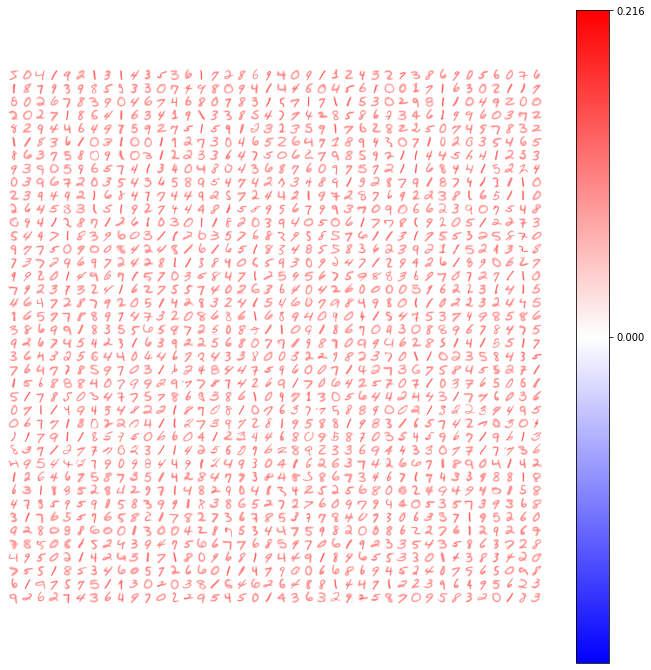

In [8]:
%matplotlib inline
# %matplotlib notebook
fig=plt.figure(figsize=(12,12))

Kx = 40
Ky = 40
Nep = 1
T_s = 60000
xi = 0.02
phi = 2 / 501

zeta = 20
beta = 0.001

B = 500 #Batch size

start = time()
N = Kx * Ky

w = flat_x[:N, :]
# w = np.abs(np.random.normal(0, 1, (N, L))) # synapses of each neuron
w = w / np.array([np.linalg.norm(w, axis=1)]).T #NORMALIZE THE WEIGHTS TO PREVENT EXXXPLOSIONS
s = np.zeros(N).reshape(-1, 1) # Specialization for each neuron+

for ep in range(Nep):
    # Uncomment the following line if you'd like to shuffle the data between epochs
    inputs = flat_x[np.random.permutation(S), :].reshape(S, L)

    for i in tqdm(range(T_s // B)):
        v = inputs[i * B: (i + 1) * B, :]

        w_mul_v = w @ v.T 
        o = w_mul_v / (np.linalg.norm(w, axis=1).reshape(-1, 1) * np.linalg.norm(v, axis=1))

        c = o

        wins = np.argmax(c, axis=0)     

        win_mask = np.zeros((N, B))
        win_mask[wins, np.arange(B)] = 1
        win_mask = (win_mask / np.maximum(np.sum(win_mask, axis=1), 1).reshape(-1, 1))

        win_avg = (np.sum(w_mul_v * win_mask, axis=1)).reshape(-1, 1)

        v_update = win_mask @ v

        del_syn = (v_update - (win_avg * w)) * xi

        w += del_syn

    draw_weights(w, Kx, Ky)

print("Max val: ", np.amax(s), "Min value: ", np.amin(s), "Mean val: ", np.mean(s), "Std: ", np.std(s))
print("Elapsed time: ", time() - start, " seconds")

wta_classification(w, T_s)
draw_weights(w, Kx, Ky)

Wow.  You hate to see it.  I'm going to do 10 epochs, and see how performance is looking.

100%|██████████| 120/120 [00:02<00:00, 44.87it/s]


Max val:  0.9296812110819777 Min value:  0.5549569273815971 Mean val:  0.8078676764163275 Std:  0.056984551371334985
Elapsed time:  29.947715282440186  seconds



Neuron classes: [5 1 6 2 0 0 7 6 9 2 3 2 6 3 7 3 2 5 6 4 3 4 5 9 4 1 2 4 5 2 3 4 0 3 0 2 2
 4 8 2 3 1 7 0 6 3 4 6 0 0 4 7 8 6 2 9 8 8 8 2 7 8 3 4 9 4 2 5 4 0 5 9 9 5
 7 2 0 3 7 6 4 0 8 9 2 5 2 4 6 3 8 0 3 5 1 4 8 1 1 6 4 4 2 8 7 9 6 0 3 3 3
 5 8 8 3 6 5 8 1 9 0 6 7 0 9 1 2 6 2 6 5 3 1 0 3 8 4 2 1 1 6 2 7 1 3 4 1 2
 1 0 5 5 1 4 1 7 9 8 1 6 0 4 2 8 2 3 9 5 8 8 9 0 5 2 3 7 3 0 7 2 5 4 0 8 8
 2 1 6 3 3 2 2 9 1 3 1 8 8 9 7 7 8 5 6 5 2 9 3 5 2 4 6 7 7 4 5 2 6 9 8 5 5
 3 6 5 8 4 9 9 7 5 7 7 2 0 8 4 6 6 2 5 2 1 7 7 0 4 3 1 7 6 5 1 2 9 4 4 9 3
 7 5 1 6 2 1 0 5 5 3 0 6 8 4 3 0 4 8 7 9 3 0 2 7 7 0 4 6 4 7 9 6 2 9 5 3 9
 2 9 5 3 8 2 8 6 8 0 4 0 1 6 0 4 0 0 7 9 5 0 3 0 4 9 1 8 1 3 2 7 5 4 4 0 3
 8 0 5 9 4 6 6 4 7 2 3 2 6 2 8 1 9 6 6 3 0 9 1 5 0 7 9 8 3 1 5 9 7 6 4 0 6
 0 5 3 0 3 6 5 5 9 5 2 6 3 4 1 2 2 6 2 7 7 3 6 3 2 1 0 9 9 8]
Accuracy:

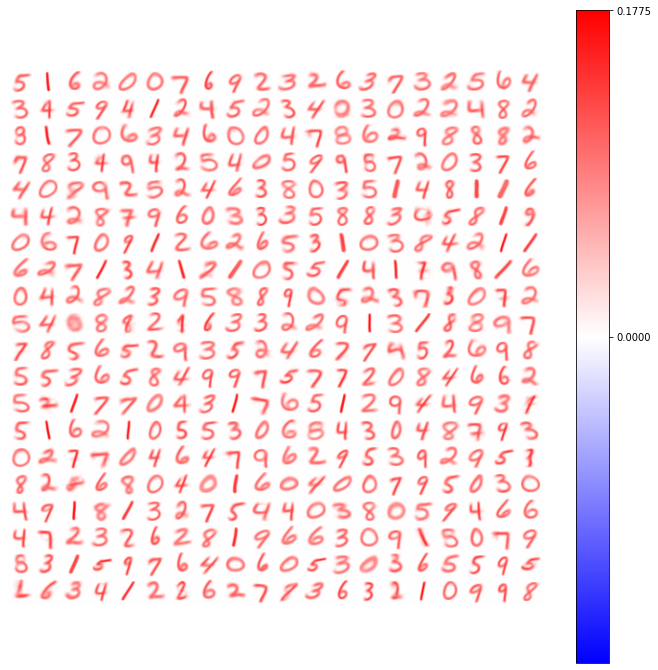

In [9]:
%matplotlib inline
# %matplotlib notebook
fig=plt.figure(figsize=(12,12))

Kx = 20
Ky = 20
Nep = 10
T_s = 60000
xi = 0.1
phi = 2 / 501

zeta = 200
beta = 0.01

B = 500 #Batch size

(w, _) = run_comp_spec_mb(flat_x, S, L, Kx, Ky, Nep, T_s, xi, phi, B, zeta, beta)
print("\n\n")
wta_classification(w, T_s)
draw_weights(w, Kx, Ky)

100%|██████████| 120/120 [00:02<00:00, 54.05it/s]


Max val:  0.0 Min value:  0.0 Mean val:  0.0 Std:  0.0
Elapsed time:  25.222450971603394  seconds
Neuron classes: [5 0 4 1 4 2 1 3 1 4 3 5 5 6 1 7 2 8 6 7 4 0 9 1 2 2 4 3 2 4 5 8 6 9 0 5 6
 0 3 6 7 8 7 9 3 9 8 5 3 3 3 0 7 9 4 7 0 9 9 1 4 4 6 5 4 5 6 5 0 0 2 9 8 6
 3 0 2 6 8 7 8 0 2 6 7 8 3 9 0 4 6 7 4 6 8 0 7 8 3 7 5 7 1 7 1 1 6 3 5 2 9
 8 1 1 0 4 9 3 0 0 2 0 2 7 1 5 6 8 8 6 3 9 2 9 1 3 5 8 3 4 2 7 4 2 8 5 8 6
 2 3 9 6 1 4 4 6 0 3 7 2 8 2 9 4 4 6 9 4 7 0 9 2 7 5 1 5 9 1 2 3 2 8 5 8 1
 7 6 2 8 2 2 5 0 7 4 9 7 8 3 8 9 1 5 3 6 5 0 2 5 0 0 1 9 2 7 3 0 4 6 5 2 6
 9 7 2 3 9 9 3 0 7 8 0 2 0 3 5 4 6 5 8 6 3 7 3 3 0 9 2 0 3 3 2 2 5 3 0 7 7
 5 0 6 2 7 4 3 8 8 2 1 1 9 4 5 2 4 1 2 5 3 7 3 9 6 3 9 5 5 7 4 1 3 4 0 4 8
 6 4 5 6 5 7 6 8 7 7 5 7 2 1 1 6 8 4 4 8 8 2 2 9 0 5 9 6 9 2 0 3 5 4 3 6 5
 8 4 5 4 2 9 2 7 3 4 8 9 1 4 2 8 7 9 5 5 7 4 7 3 8 1 0 2 3 4 4 9 2 1 6 8 4
 7 7 4 4 9 2 5 9 2 4 6 2 3 9 7 2 8 7 6 9 2 2 3 8 1 6 5 1 8 0]
Accuracy: 93.37%
Misclassifieds:  [ 15.  18.  50.  73. 128.  81.  26.  71.

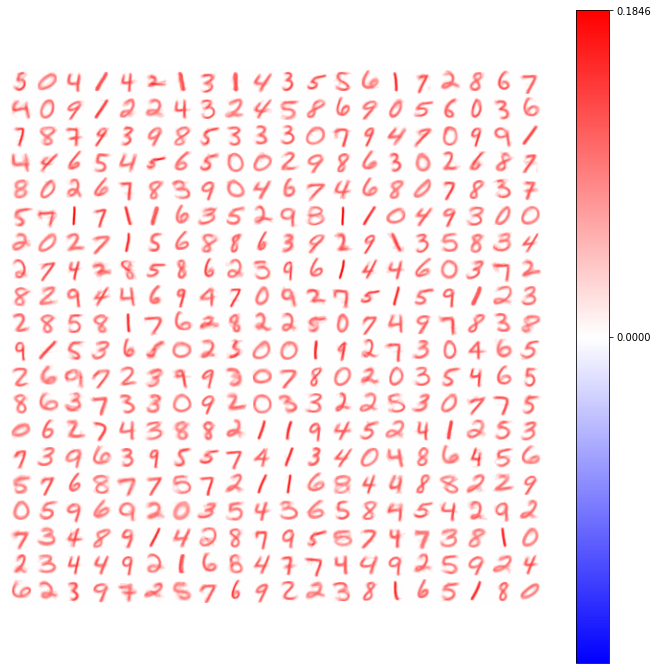

In [10]:
%matplotlib inline
# %matplotlib notebook
fig=plt.figure(figsize=(12,12))

Kx = 20
Ky = 20
Nep = 10
T_s = 60000
xi = 0.02
phi = 2 / 501

zeta = 20
beta = 0.001

B = 500 #Batch size

start = time()
N = Kx * Ky

w = flat_x[:N, :]
# w = np.abs(np.random.normal(0, 1, (N, L))) # synapses of each neuron
w = w / np.array([np.linalg.norm(w, axis=1)]).T #NORMALIZE THE WEIGHTS TO PREVENT EXXXPLOSIONS
s = np.zeros(N).reshape(-1, 1) # Specialization for each neuron+

for ep in range(Nep):
    # Uncomment the following line if you'd like to shuffle the data between epochs
    inputs = flat_x[np.random.permutation(S), :].reshape(S, L)

    for i in tqdm(range(T_s // B)):
        v = inputs[i * B: (i + 1) * B, :]

        w_mul_v = w @ v.T 
        o = w_mul_v / (np.linalg.norm(w, axis=1).reshape(-1, 1) * np.linalg.norm(v, axis=1))

        c = o

        wins = np.argmax(c, axis=0)     

        win_mask = np.zeros((N, B))
        win_mask[wins, np.arange(B)] = 1
        win_mask = (win_mask / np.maximum(np.sum(win_mask, axis=1), 1).reshape(-1, 1))

        win_avg = (np.sum(w_mul_v * win_mask, axis=1)).reshape(-1, 1)

        v_update = win_mask @ v

        del_syn = (v_update - (win_avg * w)) * xi

        w += del_syn

    draw_weights(w, Kx, Ky)

print("Max val: ", np.amax(s), "Min value: ", np.amin(s), "Mean val: ", np.mean(s), "Std: ", np.std(s))
print("Elapsed time: ", time() - start, " seconds")

wta_classification(w, T_s)
draw_weights(w, Kx, Ky)

100%|██████████| 120/120 [00:10<00:00, 11.80it/s]


Max val:  0.9300125572800599 Min value:  0.052126953769556714 Mean val:  0.5713747950138263 Std:  0.1522912118468627
Elapsed time:  104.69855117797852  seconds



Neuron classes: [2 1 4 ... 4 2 5]
Accuracy: 94.91%
Misclassifieds:  [11.  8. 38. 73. 69. 58. 16. 81. 65. 90.]


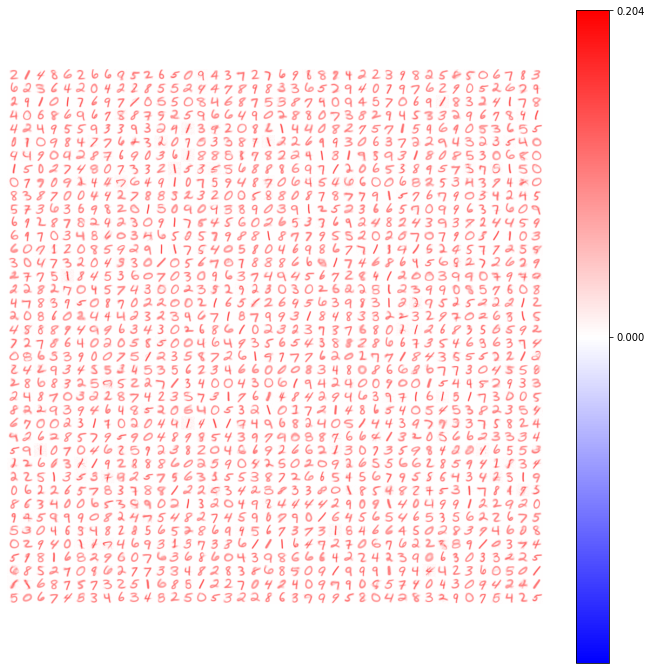

In [11]:
%matplotlib inline
# %matplotlib notebook
fig=plt.figure(figsize=(12,12))

Kx = 40
Ky = 40
Nep = 10
T_s = 60000
xi = 0.1
phi = 2 / 501

zeta = 200
beta = 0.01

B = 500 #Batch size

(w, _) = run_comp_spec_mb(flat_x, S, L, Kx, Ky, Nep, T_s, xi, phi, B, zeta, beta)
print("\n\n")
wta_classification(w, T_s)
draw_weights(w, Kx, Ky)

100%|██████████| 120/120 [00:08<00:00, 13.82it/s]


Max val:  0.0 Min value:  0.0 Mean val:  0.0 Std:  0.0
Elapsed time:  88.6474883556366  seconds
Neuron classes: [5 0 4 ... 1 2 3]
Accuracy: 95.71%
Misclassifieds:  [11.  6. 40. 60. 54. 54. 13. 64. 57. 70.]


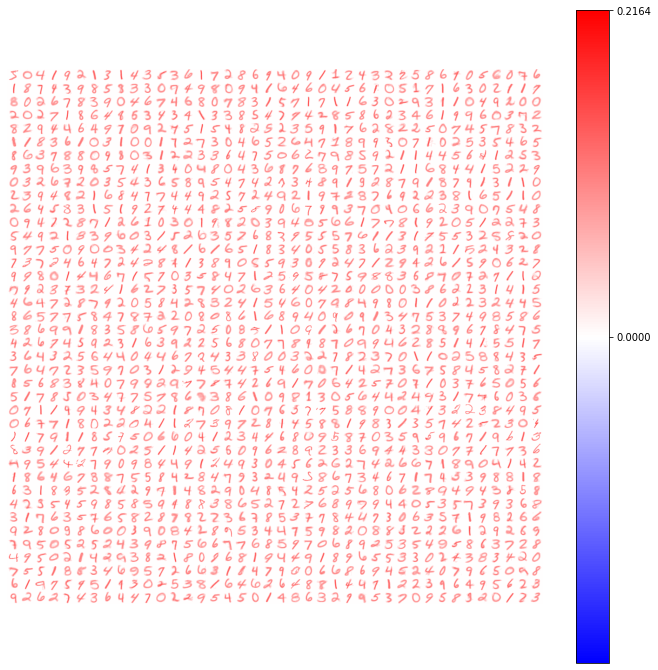

In [12]:
%matplotlib inline
# %matplotlib notebook
fig=plt.figure(figsize=(12,12))

Kx = 40
Ky = 40
Nep = 10
T_s = 60000
xi = 0.02
phi = 2 / 501

zeta = 20
beta = 0.001

B = 500 #Batch size

start = time()
N = Kx * Ky

w = flat_x[:N, :]
# w = np.abs(np.random.normal(0, 1, (N, L))) # synapses of each neuron
w = w / np.array([np.linalg.norm(w, axis=1)]).T #NORMALIZE THE WEIGHTS TO PREVENT EXXXPLOSIONS
s = np.zeros(N).reshape(-1, 1) # Specialization for each neuron+

for ep in range(Nep):
    # Uncomment the following line if you'd like to shuffle the data between epochs
    inputs = flat_x[np.random.permutation(S), :].reshape(S, L)

    for i in tqdm(range(T_s // B)):
        v = inputs[i * B: (i + 1) * B, :]

        w_mul_v = w @ v.T 
        o = w_mul_v / (np.linalg.norm(w, axis=1).reshape(-1, 1) * np.linalg.norm(v, axis=1))

        c = o

        wins = np.argmax(c, axis=0)     

        win_mask = np.zeros((N, B))
        win_mask[wins, np.arange(B)] = 1
        win_mask = (win_mask / np.maximum(np.sum(win_mask, axis=1), 1).reshape(-1, 1))

        win_avg = (np.sum(w_mul_v * win_mask, axis=1)).reshape(-1, 1)

        v_update = win_mask @ v

        del_syn = (v_update - (win_avg * w)) * xi

        w += del_syn

    draw_weights(w, Kx, Ky)

print("Max val: ", np.amax(s), "Min value: ", np.amin(s), "Mean val: ", np.mean(s), "Std: ", np.std(s))
print("Elapsed time: ", time() - start, " seconds")

wta_classification(w, T_s)
draw_weights(w, Kx, Ky)

Well, shit.  Rip me.  I'm a fucking deag.  Out of curiosity, I'm going to try 6,400 neurons and see how good it is.

100%|██████████| 120/120 [00:36<00:00,  3.41it/s]


Max val:  0.0 Min value:  0.0 Mean val:  0.0 Std:  0.0
Elapsed time:  364.4417550563812  seconds
Neuron classes: [5 0 4 ... 7 3 5]
Accuracy: 96.48%
Misclassifieds:  [ 6.  6. 29. 45. 53. 45. 18. 48. 50. 52.]


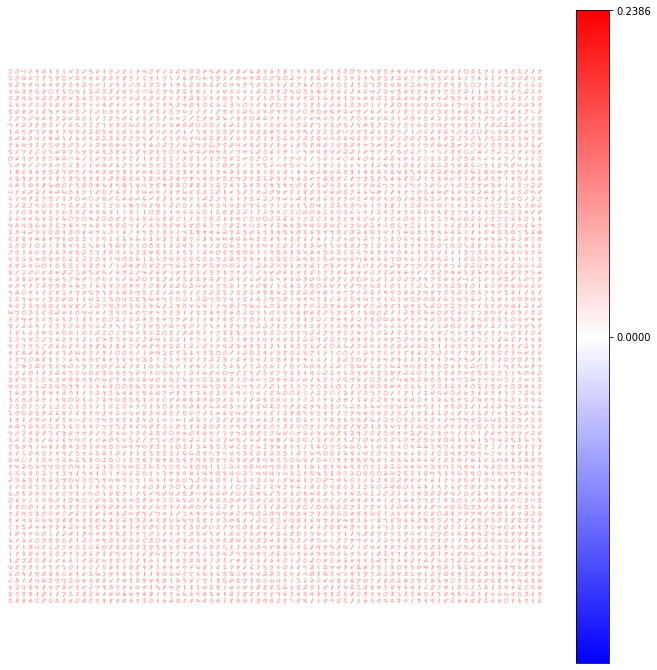

In [13]:
%matplotlib inline
# %matplotlib notebook
fig=plt.figure(figsize=(12,12))

Kx = 80
Ky = 80
Nep = 10
T_s = 60000
xi = 0.02
phi = 2 / 501

zeta = 20
beta = 0.001

B = 500 #Batch size

start = time()
N = Kx * Ky

w = flat_x[:N, :]
# w = np.abs(np.random.normal(0, 1, (N, L))) # synapses of each neuron
w = w / np.array([np.linalg.norm(w, axis=1)]).T #NORMALIZE THE WEIGHTS TO PREVENT EXXXPLOSIONS
s = np.zeros(N).reshape(-1, 1) # Specialization for each neuron+

for ep in range(Nep):
    # Uncomment the following line if you'd like to shuffle the data between epochs
    inputs = flat_x[np.random.permutation(S), :].reshape(S, L)

    for i in tqdm(range(T_s // B)):
        v = inputs[i * B: (i + 1) * B, :]

        w_mul_v = w @ v.T 
        o = w_mul_v / (np.linalg.norm(w, axis=1).reshape(-1, 1) * np.linalg.norm(v, axis=1))

        c = o

        wins = np.argmax(c, axis=0)     

        win_mask = np.zeros((N, B))
        win_mask[wins, np.arange(B)] = 1
        win_mask = (win_mask / np.maximum(np.sum(win_mask, axis=1), 1).reshape(-1, 1))

        win_avg = (np.sum(w_mul_v * win_mask, axis=1)).reshape(-1, 1)

        v_update = win_mask @ v

        del_syn = (v_update - (win_avg * w)) * xi

        w += del_syn

    draw_weights(w, Kx, Ky)

print("Max val: ", np.amax(s), "Min value: ", np.amin(s), "Mean val: ", np.mean(s), "Std: ", np.std(s))
print("Elapsed time: ", time() - start, " seconds")

wta_classification(w, T_s)
draw_weights(w, Kx, Ky)

This is getting about the same classification accuracy as the CompSpec network from the last problem.  Out of curiosity...

In [14]:
wta_classification(flat_x[:6400], 60000)

Neuron classes: [5 0 4 ... 7 3 5]
Accuracy: 94.49%
Misclassifieds:  [11. 11. 60. 73. 65. 83. 23. 80. 71. 74.]


Yup, I thought it might be something like that.  I'm going to try that with 100, 400, and 1,600 neurons now.

In [15]:
wta_classification(flat_x[:100], 60000)

Neuron classes: [5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9 4 0 4 1 2 2 4 3 2 7 3 8 6 7 0 5 6
 0 7 6 1 8 7 9 3 9 8 5 8 3 3 0 7 4 4 8 0 9 4 1 4 4 6 0 4 5 6 1 0 0 2 7 1 6
 3 0 2 1 1 7 5 5 2 6 7 8 3 9 0 4 6 7 4 6 8 0 7 8 3 1]
Accuracy: 72.73%
Misclassifieds:  [ 62.  22. 258. 121. 287. 608. 173. 251. 410. 535.]


In [16]:
wta_classification(flat_x[:400], 60000)

Neuron classes: [5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9 4 0 9 1 1 2 4 3 2 7 3 8 6 9 0 5 6
 0 7 6 1 8 7 9 3 9 8 5 8 3 3 0 7 4 9 8 0 9 4 1 4 4 6 0 4 5 6 5 0 0 1 7 1 6
 3 0 2 1 2 7 5 0 2 6 7 8 3 9 0 4 6 7 4 6 8 0 7 8 3 1 5 7 1 7 1 1 6 3 0 2 9
 3 1 1 0 4 9 2 0 0 2 0 2 7 1 8 6 4 1 6 3 4 1 9 1 3 3 8 5 4 7 7 4 2 8 5 8 6
 2 3 4 6 1 9 9 6 0 3 7 2 8 2 9 4 4 6 4 9 7 0 9 2 7 5 1 5 9 1 0 3 2 8 5 9 1
 7 6 2 8 2 2 5 0 7 4 9 7 8 3 2 1 1 5 3 6 1 0 8 1 0 0 1 7 2 7 3 0 4 6 5 2 6
 9 7 1 8 9 9 3 0 7 1 0 2 0 3 5 4 6 5 8 6 3 7 5 8 0 9 1 0 2 1 2 2 3 3 6 4 7
 5 0 6 2 7 9 8 5 9 2 1 1 4 4 5 6 4 1 2 3 3 9 3 9 0 5 9 6 5 7 4 1 3 4 0 4 8
 0 4 3 6 8 7 6 0 9 7 5 7 2 1 1 6 8 9 4 1 5 2 2 9 0 3 9 6 7 2 0 3 5 4 3 6 5
 8 9 5 4 7 4 2 4 3 4 8 9 1 5 2 8 7 9 1 8 7 4 1 3 1 1 0 2 3 9 4 9 2 1 6 8 4
 7 7 4 4 9 2 5 7 2 4 4 2 1 9 7 2 8 7 6 9 2 2 3 8 1 6 5 1 1 0]
Accuracy: 84.51%
Misclassifieds:  [ 23.  15. 137. 125. 229. 312. 107. 180. 260. 161.]


In [17]:
wta_classification(flat_x[:1600], 60000)

Neuron classes: [5 0 4 ... 1 3 3]
Accuracy: 90.44%
Misclassifieds:  [ 16.  19. 116. 109. 154. 148.  40.  88. 149. 117.]


Well that's at least somewhat encouraging.  I'm trying to figure out how I can make CompSpec behave more like this random initialization.  You know what, I was using $1 / (1 - o)$ in the CompSpec algo. I'm going to change that and see if it makes things better.

In [7]:
"""
flat_x: training data
S: Size of training set
L: Size of input
Kx: Num cols of neurons
Ky: Num rows of neurons
Nep: Num epochs
T_s: Number of training inputs
xi: Base learning constant
phi: Specialization ema constant
B: Batch size

zeta: Brutality of exponent
beta: giver of life lol

Returns: (synapse_weights, neuron specialization values)
"""
def run_comp_spec_mb(flat_x, S, L, Kx, Ky, Nep, T_s, xi, phi, B, zeta, beta):
    start = time()
    N = Kx * Ky
    
    w = np.abs(np.random.normal(0, 1, (N, L))) # synapses of each neuron
    w = w / np.array([np.linalg.norm(w, axis=1)]).T #NORMALIZE THE WEIGHTS TO PREVENT EXXXPLOSIONS
    s = np.zeros(N).reshape(-1, 1) # Specialization for each neuron+

    for ep in range(Nep):
        # Uncomment the following line if you'd like to shuffle the data between epochs
        inputs = flat_x[np.random.permutation(S), :].reshape(S, L)

        for i in tqdm(range(T_s // B)):
            v = inputs[i * B: (i + 1) * B, :]

            w_mul_v = w @ v.T 
            o = w_mul_v / (np.linalg.norm(w, axis=1).reshape(-1, 1) * np.linalg.norm(v, axis=1))

            c = (np.exp(-1 * zeta * s) + beta) * o

            wins = np.argmax(c, axis=0)     

            win_mask = np.zeros((N, B))
            win_mask[wins, np.arange(B)] = 1
            win_mask = (win_mask / np.maximum(np.sum(win_mask, axis=1), 1).reshape(-1, 1))

            win_avg = (np.sum(w_mul_v * win_mask, axis=1)).reshape(-1, 1)

            v_update = win_mask @ v

            del_syn = (v_update - (win_avg * w)) * (np.exp(-1 * zeta * s) + beta) * xi

            w += del_syn

            s[wins] *= (1 - phi)
            s += phi * np.sum(o * win_mask, axis=1).reshape(-1, 1)

        draw_weights(w, Kx, Ky)

    print("Max val: ", np.amax(s), "Min value: ", np.amin(s), "Mean val: ", np.mean(s), "Std: ", np.std(s))
    print("Elapsed time: ", time() - start, " seconds")
    
    return (w, s)

100%|██████████| 120/120 [00:09<00:00, 12.20it/s]


Max val:  0.9246603721662173 Min value:  0.04553057786818087 Mean val:  0.5542340563397798 Std:  0.15865382201070466
Elapsed time:  101.82762670516968  seconds



Neuron classes: [8 2 2 ... 1 0 8]
Accuracy: 94.56%
Misclassifieds:  [ 10.  12.  42.  78.  86.  57.  21.  65.  69. 104.]


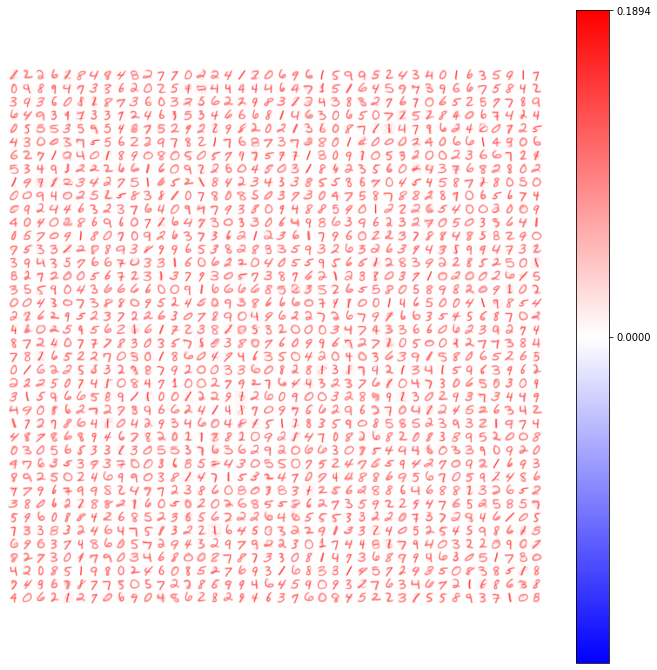

In [19]:
%matplotlib inline
# %matplotlib notebook
fig=plt.figure(figsize=(12,12))

Kx = 40
Ky = 40
Nep = 10
T_s = 60000
xi = 0.1
phi = 2 / 501

zeta = 200
beta = 0.01

B = 500 #Batch size

(w, _) = run_comp_spec_mb(flat_x, S, L, Kx, Ky, Nep, T_s, xi, phi, B, zeta, beta)
print("\n\n")
wta_classification(w, T_s)
draw_weights(w, Kx, Ky)

One more thing I'm going to try here.

100%|██████████| 120/120 [00:09<00:00, 12.26it/s]


Max val:  0.9016764091490255 Min value:  0.12535028826036768 Mean val:  0.5936340877408913 Std:  0.10782654940646225
Elapsed time:  101.18341636657715  seconds



Neuron classes: [4 2 4 ... 8 8 6]
Accuracy: 96.05%
Misclassifieds:  [12.  8. 30. 65. 56. 46. 12. 61. 42. 63.]


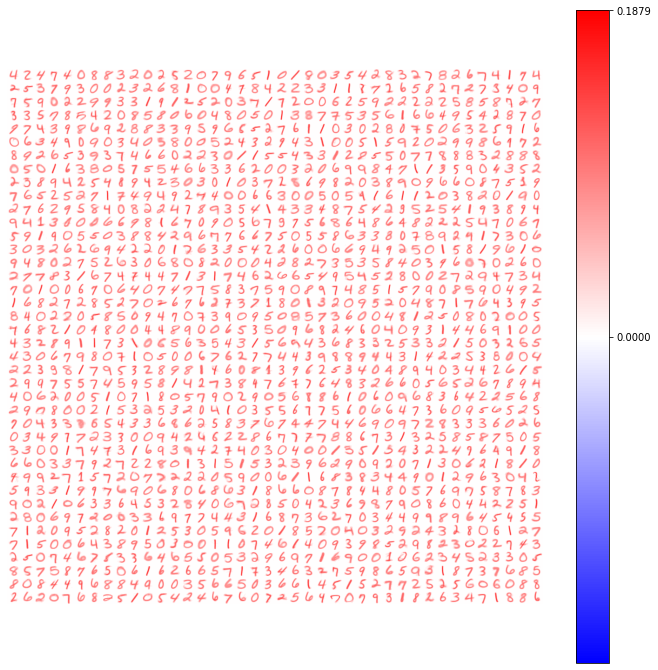

In [20]:
%matplotlib inline
# %matplotlib notebook
fig=plt.figure(figsize=(12,12))

Kx = 40
Ky = 40
Nep = 10
T_s = 60000
xi = 0.1
phi = 2 / 501

zeta = 200
beta = 0.1

B = 500 #Batch size

(w, _) = run_comp_spec_mb(flat_x, S, L, Kx, Ky, Nep, T_s, xi, phi, B, zeta, beta)
print("\n\n")
wta_classification(w, T_s)
draw_weights(w, Kx, Ky)

Shoot dang. I just needed to up beta a bit.  I'm going to try this with 100 neurons just cause it goes faster.

100%|██████████| 120/120 [00:00<00:00, 208.53it/s]


Max val:  0.9008910984909724 Min value:  0.7357373131107613 Mean val:  0.8153694970517119 Std:  0.03567015386967179
Elapsed time:  8.556614398956299  seconds



Neuron classes: [8 0 2 4 9 1 9 1 4 5 4 9 7 3 8 6 6 0 9 8 5 0 5 7 9 2 7 0 1 0 0 2 7 9 1 3 7
 3 4 6 7 6 8 4 5 6 0 8 3 9 2 6 5 9 5 0 4 1 4 5 1 8 2 3 2 1 3 8 1 6 1 0 8 0
 9 5 5 4 3 6 6 0 7 2 6 7 7 9 0 2 7 4 3 2 2 3 6 7 4 4]
Accuracy: 90.42%
Misclassifieds:  [ 19.  14.  89. 118. 187. 137.  35. 107. 125. 127.]


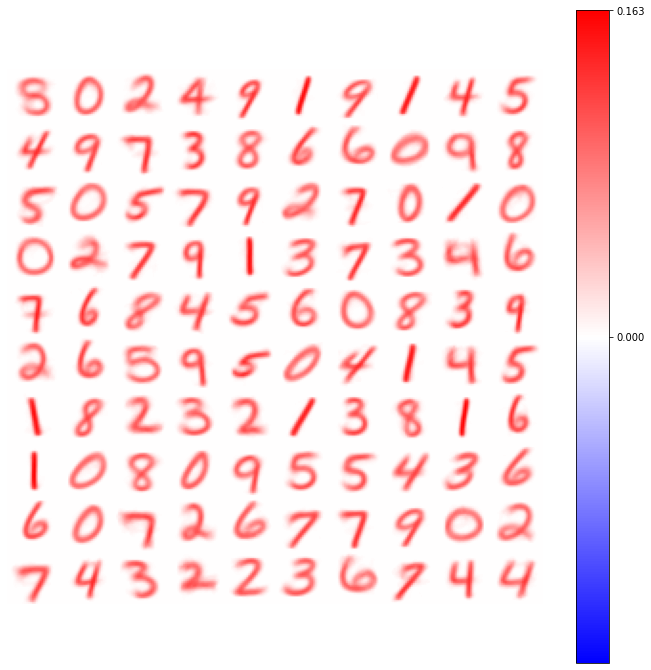

In [27]:
%matplotlib inline
# %matplotlib notebook
fig=plt.figure(figsize=(12,12))

Kx = 10
Ky = 10
Nep = 10
T_s = 60000
xi = 0.1
phi = 2 / 501

zeta = 200
beta = 0.1

B = 500 #Batch size

(w, _) = run_comp_spec_mb(flat_x, S, L, Kx, Ky, Nep, T_s, xi, phi, B, zeta, beta)
print("\n\n")
wta_classification(w, T_s)
draw_weights(w, Kx, Ky)

100%|██████████| 120/120 [00:00<00:00, 217.57it/s]


Max val:  0.0 Min value:  0.0 Mean val:  0.0 Std:  0.0
Elapsed time:  8.399571657180786  seconds
Neuron classes: [5 0 4 1 4 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9 4 0 9 1 2 2 9 3 2 4 3 8 6 7 0 5 6
 0 7 6 1 8 9 7 3 9 8 5 9 3 3 0 7 4 4 5 0 9 4 1 4 2 6 5 9 5 6 1 0 5 2 7 1 6
 3 0 2 1 8 7 5 5 2 6 7 8 5 9 0 4 6 7 9 6 8 0 7 8 8 1]
Accuracy: 89.76%
Misclassifieds:  [ 18.  19.  82. 139. 216. 114.  27. 117. 159. 133.]


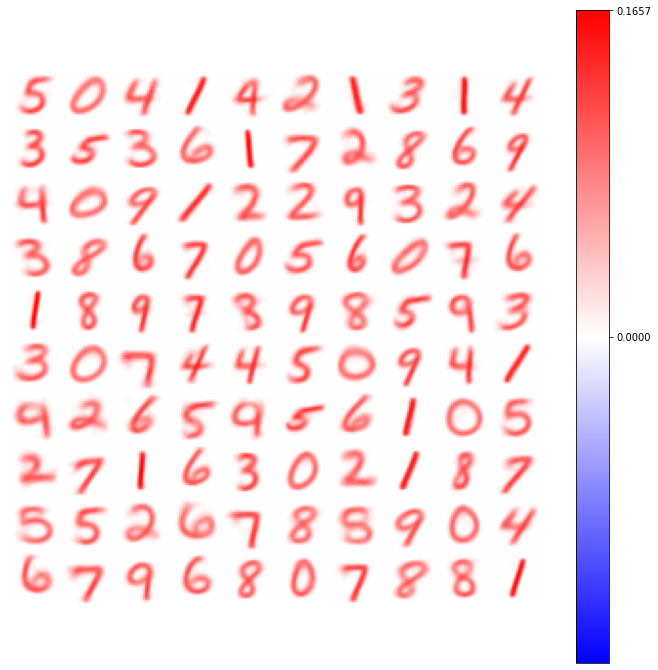

In [25]:
%matplotlib inline
# %matplotlib notebook
fig=plt.figure(figsize=(12,12))

Kx = 10
Ky = 10
Nep = 10
T_s = 60000
xi = 0.01
phi = 2 / 501

zeta = 20
beta = 0.001

B = 500 #Batch size

start = time()
N = Kx * Ky

w = flat_x[:N, :]
# w = np.abs(np.random.normal(0, 1, (N, L))) # synapses of each neuron
w = w / np.array([np.linalg.norm(w, axis=1)]).T #NORMALIZE THE WEIGHTS TO PREVENT EXXXPLOSIONS
s = np.zeros(N).reshape(-1, 1) # Specialization for each neuron+

for ep in range(Nep):
    # Uncomment the following line if you'd like to shuffle the data between epochs
    inputs = flat_x[np.random.permutation(S), :].reshape(S, L)

    for i in tqdm(range(T_s // B)):
        v = inputs[i * B: (i + 1) * B, :]

        w_mul_v = w @ v.T 
        o = w_mul_v / (np.linalg.norm(w, axis=1).reshape(-1, 1) * np.linalg.norm(v, axis=1))

        c = o

        wins = np.argmax(c, axis=0)     

        win_mask = np.zeros((N, B))
        win_mask[wins, np.arange(B)] = 1
        win_mask = (win_mask / np.maximum(np.sum(win_mask, axis=1), 1).reshape(-1, 1))

        win_avg = (np.sum(w_mul_v * win_mask, axis=1)).reshape(-1, 1)

        v_update = win_mask @ v

        del_syn = (v_update - (win_avg * w)) * xi

        w += del_syn

    draw_weights(w, Kx, Ky)

print("Max val: ", np.amax(s), "Min value: ", np.amin(s), "Mean val: ", np.mean(s), "Std: ", np.std(s))
print("Elapsed time: ", time() - start, " seconds")

wta_classification(w, T_s)
draw_weights(w, Kx, Ky)

Ok, so these two are comparable.  The reason why I want CompSpec more than just initializing to random inputs is because deeper in the network, there might not be coherent data to which we can initialize the network.  With that said, I want to try something.

100%|██████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 215.63it/s]


Max val:  0.8243912610932277 Min value:  0.6366127323394115 Mean val:  0.7777286794174669 Std:  0.030451522430168645
Elapsed time:  8.479939699172974  seconds


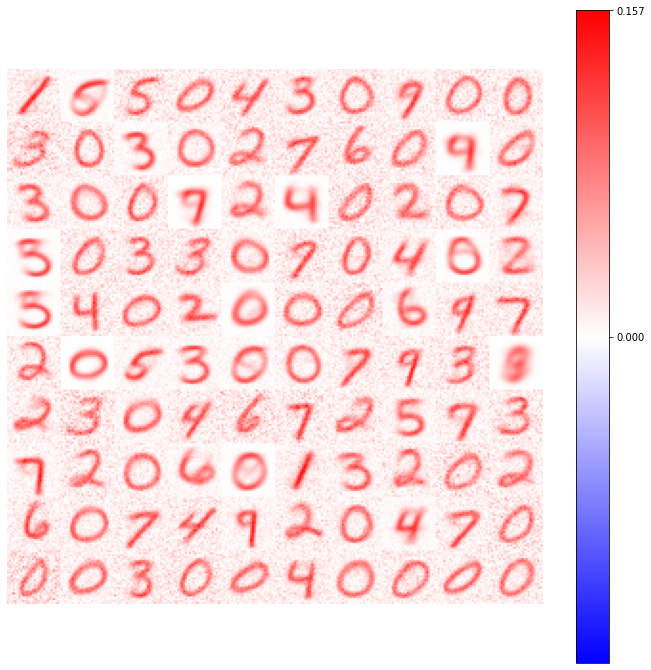

In [6]:
%matplotlib inline
fig=plt.figure(figsize=(12,12))

Kx = 10
Ky = 10
Nep = 10
T_s = 60000
xi = 0.001
phi = 2 / 11

zeta = 20
beta = 0.001

B = 500 #Batch size

start = time()
N = Kx * Ky

w = np.abs(np.random.normal(0, 1, (N, L))) # synapses of each neuron
w = w / np.array([np.linalg.norm(w, axis=1)]).T #NORMALIZE THE WEIGHTS TO PREVENT EXXXPLOSIONS
s = np.zeros(N).reshape(-1, 1) # Specialization for each neuron+

for ep in range(Nep):
    # Uncomment the following line if you'd like to shuffle the data between epochs
    inputs = flat_x[np.random.permutation(S), :].reshape(S, L)

    for i in tqdm(range(T_s // B)):
        v = inputs[i * B: (i + 1) * B, :]

        w_mul_v = w @ v.T 
        o = w_mul_v / (np.linalg.norm(w, axis=1).reshape(-1, 1) * np.linalg.norm(v, axis=1))

        c = (1 - s) * o

        wins = np.argmax(c, axis=0)     

        win_mask = np.zeros((N, B))
        win_mask[wins, np.arange(B)] = 1
        win_mask = (win_mask / np.maximum(np.sum(win_mask, axis=1), 1).reshape(-1, 1))

        win_avg = (np.sum(w_mul_v * win_mask, axis=1)).reshape(-1, 1)

        v_update = win_mask @ v

        del_syn = (v_update - (win_avg * w)) * xi

        w += del_syn

        s[wins] *= (1 - phi)
        s += phi * np.sum(o * win_mask, axis=1).reshape(-1, 1)

    draw_weights(w, Kx, Ky)

print("Max val: ", np.amax(s), "Min value: ", np.amin(s), "Mean val: ", np.mean(s), "Std: ", np.std(s))
print("Elapsed time: ", time() - start, " seconds")

Ok, that's kinda a flop.  I think I'm going to give extra bonuses to neurons below 0.1, but that's it.

<IPython.core.display.Javascript object>


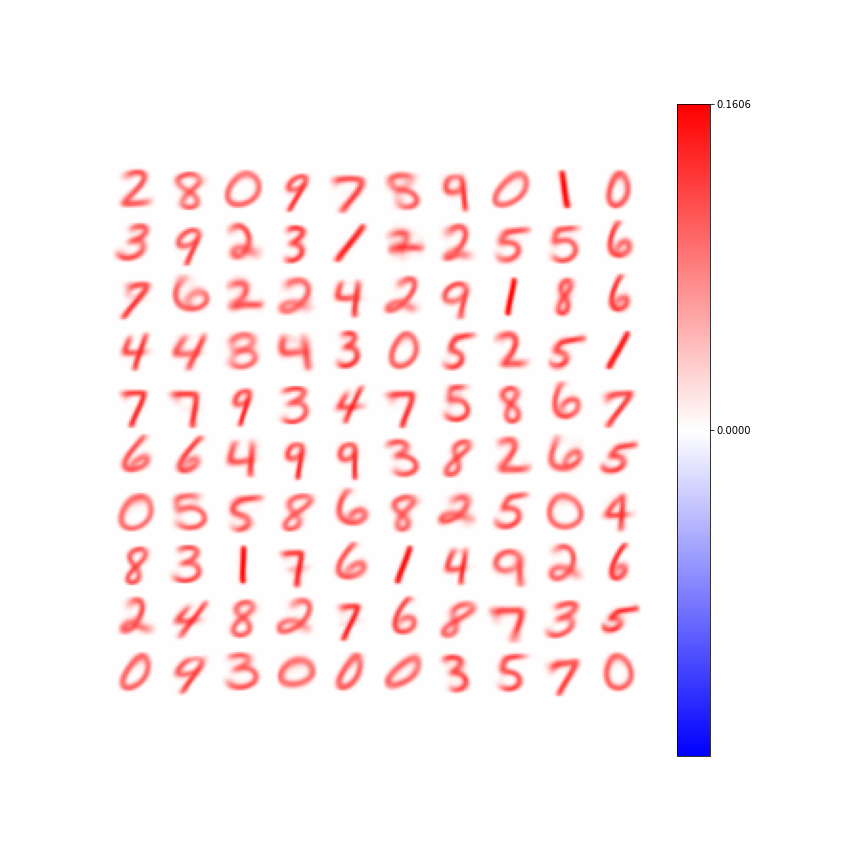

100%|██████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 209.62it/s]


Max val:  0.906768368249057 Min value:  0.7251703726204206 Mean val:  0.8204215419646039 Std:  0.031678180593651205
Elapsed time:  27.764009714126587  seconds



Neuron classes: [2 8 0 9 7 8 9 0 1 0 3 9 2 3 1 2 2 5 5 6 7 6 2 2 4 2 9 1 8 6 4 4 8 4 3 0 5
 2 5 1 7 7 9 3 4 7 5 8 6 7 6 6 4 9 9 3 8 2 6 5 0 5 5 8 6 8 2 5 0 4 8 3 1 7
 6 1 4 9 2 6 2 4 8 2 7 6 8 7 3 5 0 9 3 0 0 0 3 5 7 0]
Accuracy: 90.17%
Misclassifieds:  [ 19.  19.  67. 150. 232.  97.  36. 117.  98. 148.]


<IPython.core.display.Javascript object>


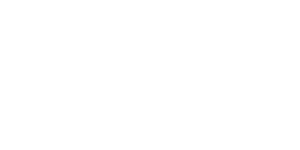

In [14]:
%matplotlib inline
%matplotlib notebook
fig=plt.figure(figsize=(12,12))

Kx = 10
Ky = 10
Nep = 30
T_s = 60000
xi = 0.1
phi = 2 / 501

zeta = 200
beta = 0.01

B = 500 #Batch size

(w, _) = run_comp_spec_mb(flat_x, S, L, Kx, Ky, Nep, T_s, xi, phi, B, zeta, beta)
print("\n\n")
wta_classification(w, T_s)
draw_weights(w, Kx, Ky)

Actually, I think the best strat is to just super small phi and big zeta.  Basically the huge zeta ensures that neurons aren't treated differently if they have different specialization, which is likely because some neurons need to be more general than others (8s, for example), but the big value of phi ensures that the neurons don't reach that specialization quickly, which makes the learning constant artificially higher, which, in turn, allows the neurons to reach the neighborhood of their final value quickly (getting rid of weights in the whitespace, for mnist).  

## Conclusions

Well, this experiment was somewhat humbling.  I thought I was all cool with CompSpec, but really the boost just comes from initializing weights as prototypes.  Bloody fantastic.  That being said, CompSpec still is somewhat valuable because it gets the prototypes where they need to go quickly, and then allows the network to update the weights using a very small learning constant to stabilize learning. That being said, the whole process could be made more efficient.  I don't really need all the fancy exponentials.  

But it's still super fast, so for the time being, I'm going to use it.  When I need more efficiency, I can build more efficiency.

## Next steps

Now I need to see how I can bump up accuracy.  There are a couple reasonable things to try.  

1. Train multiple networks, and take the average classification.
2. Train neurons on smaller pieces of the image, learn hierarchy of features.

So yeah.  I got this locked down.